# Lab 3: Regularized Least Square
In this lab, we focus on RLS to address linear regression problems. 

In this lab, we have to:
- **(Task 1)** implement RLS to solve linear regression problems
- **(Task 2)** observe performance of RLS changing the noise in the data and the regularization parameter
- **(Task 3)** implement K-Fold Cross-Validation algorithm for RLS


In [2]:
#Matteo Pastorino Ghezzi
#Riccardo Caprile
#Andrea Valli

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

## Data generation
To generate linear regression data, we use the `linearRegrFunction` introduced in Lab0.

In [4]:
def linearRegrFunction(n, D, low_D, high_D, W, sigma_noise):
    X = np.zeros((n,D))
    for i in range(0, D):
        X[:,i] = np.random.uniform(low_D[i], high_D[i], size=n)
    
    gauss_noise = np.random.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X, W) + gauss_noise
    
    return X, Y 

### Example: Noiseless dataset


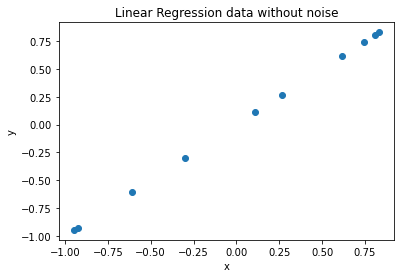

In [5]:
n = 10
D = 1
low_D, high_D = [-1], [1]
w = np.array(1.0).reshape(1, 1)
noise_std = 0.0

# Data generation
X, Y = linearRegrFunction(n, D, low_D, high_D, w, noise_std)

# Plot of the data
_, ax = plt.subplots()
ax.set_title("Linear Regression data without noise")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X, Y)

## Task 1: RLS regressor
We want to implement the `regularizedLSTrain` function which train RLS regression.

The signature of `regularizedLSTrain` is the following:

`w = regularizedLSTrain(Xtr, Ytr, lam)`

where:
- **Xtr** are the training inputs
- **Ytr** are the training outputs
- **lam** is the regularization parameter $\lambda$

To implement this function, you will need to use the following functions from numpy:

- [`np.linalg.cholesky`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html)
- [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html)

Consider 

**$(X_{tr}^\intercal X_{tr} + \lambda n I)w = X_{tr}^\intercal Y_{tr}$**

Let $A = X_{tr}^\intercal X_{tr} + \lambda n I$ and $b = X_{tr}^\intercal Y_{tr}$, we can find $w$ with the following steps:
1. First build the left-hand side matrix `A`, and the right-hand side matrix `b`.
2. Compute the Cholesky decomposition of `A` (note that the numpy function will provide a lower-triangular matrix)
3. You will have to solve two triangular systems, one using the Cholesky decomposition, and the other using its transpose.

In [7]:
def regularizedLSTrain(Xtr, Ytr, lam):
    # A matrix
    #n=np.shape(Xtr)
    n,d=Xtr.shape
    Xtr_trans=np.transpose(Xtr)
    #I_matrix=np.identity(np.shape(Xtr))
    I_matrix=np.eye(d)
    #A = Xtr_trans*Xtr + lam*n*I_matrix
    A = np.matmul(Xtr_trans,Xtr) + lam*n*I_matrix

    # b matrix
    #b=Xtr_trans*Ytr
    b=np.matmul(Xtr_trans,Ytr)

    A_dec=np.linalg.cholesky(A)
    w1=scipy.linalg.solve_triangular(A_dec,b,lower=True)
    w2 = scipy.linalg.solve_triangular(np.transpose(A_dec),w1,lower=True)

    return w2

We need also to implement a function `regularizedLSTest` which given a test set `Xte` and the `w` obtained using `regularizedLSTrain`, it returns `Ypred` containing the predictions

In [8]:
def regularizedLSTest(w, Xte):
    #Xte_trans=np.transpose(Xte)
    #Ypred=Xte_trans*w
    Ypred=np.dot(Xte,w)
    return Ypred

To evaluate the performance of RLS regressor, we need a function to estimate the error.

Given two vectors `Ytrue` (real outputs) and `Ypred` (predicted outputs), we can measure the error obtained when predicting `Ypred` instead of `Ytrue` with the MSE (Mean Square Error)

In [9]:
def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

Now we can build an easy example to observe how our model works:
- Generate a training set with **ntrain** points and a test set with **ntest** points 
- Train RLS with `regularizedLSTrain` function and test it with `regularizedLSTest` on test set
- Compute the training and test error 

In [10]:
ntrain = 100
ntest = 50
D = 1
low_D = [-1] * D
high_D = [5] * D
rnd_state = np.random.RandomState(42)
w = rnd_state.randn(D, 1) 
noise_std = 0.1

lam = 1e-3

# Generate a training set with ntrain points and a test set with ntest 
Xtr, Ytr = linearRegrFunction(ntrain,D,low_D,high_D,w,noise_std)
Xte, Yte = linearRegrFunction(ntest,D,low_D,high_D,w,noise_std)

# Train RLS
w_RLS=regularizedLSTrain(Xtr,Ytr,lam)

# Compute predictions on training and test set
Ytr_pred = regularizedLSTest(w_RLS, Xtr)
Yte_pred = regularizedLSTest(w_RLS, Xte)

train_err = calcError(Ytr_pred, Ytr)
test_err = calcError(Yte_pred, Yte)

print("[--] Training error: {}\tTest error: {}".format(train_err, test_err))

[--] Training error: 0.010441399358877805	Test error: 0.009769355759867974


## Task 2: Changing $\lambda$ and noise
Now we can play with our model changing the noise level in the data and changing the $\lambda$ parameter.

Let's start by changing $\lambda$ and fixing the other parameters.

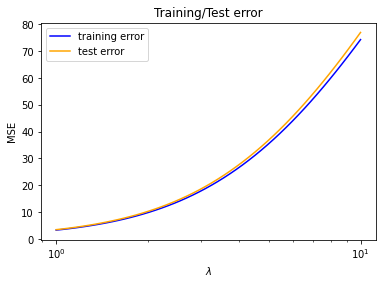

In [8]:
n = 1000
D = 5
low_D = [-5] * D
high_D = [5] * D
w = np.array([i for i in range(D)]).reshape(D, 1)
noise_std = 0.1


# Data generation
Xtr, Ytr = linearRegrFunction(n,D,low_D,high_D,w,noise_std)
Xte, Yte = linearRegrFunction(n,D,low_D,high_D,w,noise_std)

lam_list = np.logspace(1e-8, 1.0, 50)
tr_err = []
te_err = []

for lam in lam_list:

    # Train RLS
    w_RLS=regularizedLSTrain(Xtr,Ytr,lam)

    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w_RLS, Xtr)
    Yte_pred = regularizedLSTest(w_RLS, Xte)

    # Compute training and test error and store them on tr_err and te_err
    train_err = calcError(Ytr_pred, Ytr)
    test_err = calcError(Yte_pred, Yte)
    tr_err.append(train_err)
    te_err.append(test_err)

# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(lam_list, tr_err, '-', c="blue", label="training error")
ax.plot(lam_list, te_err, '-', c="orange", label="test error")
ax.legend(loc="best")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.set_xscale("log")


Explain here what happens when $\lambda$ increases: 

Now fix $\lambda = 0.1$ and change noise level

In [11]:
# ignoring the exercise as stated by Rando on Teams
'''
n = 1000
D = 10
low_D = [-5] * D
high_D = [5] * D
rnd_state = np.random.RandomState(42)
w = np.array([i for i in range(D)]).reshape(D, 1)

lam = 1e-1
noise_level = np.linspace(1e-7, 1e-1, 1000)

# Data generation

tr_err = []
te_err = []

for noise in noise_level:

    Xtr, Ytr = ...
    Xte, Yte = ...

    # Train RLS
    
    # Compute predictions on training and test set
    
    # Compute training and test error and store them on tr_err and te_err
    
    
# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(noise_level, tr_err, '-', c="blue", label="training error")
ax.plot(noise_level, te_err, '-', c="orange", label="test error")
ax.legend(loc="best")
ax.set_xlabel("noise level")
ax.set_ylabel("MSE")
ax.set_yscale("log")'''


'\nn = 1000\nD = 10\nlow_D = [-5] * D\nhigh_D = [5] * D\nrnd_state = np.random.RandomState(42)\nw = np.array([i for i in range(D)]).reshape(D, 1)\n\nlam = 1e-1\nnoise_level = np.linspace(1e-7, 1e-1, 1000)\n\n# Data generation\n\ntr_err = []\nte_err = []\n\nfor noise in noise_level:\n\n    Xtr, Ytr = ...\n    Xte, Yte = ...\n\n    # Train RLS\n    \n    # Compute predictions on training and test set\n    \n    # Compute training and test error and store them on tr_err and te_err\n    \n    \n# Plot training and test error\n_, ax = plt.subplots()\nax.set_title("Training/Test error")\nax.plot(noise_level, tr_err, \'-\', c="blue", label="training error")\nax.plot(noise_level, te_err, \'-\', c="orange", label="test error")\nax.legend(loc="best")\nax.set_xlabel("noise level")\nax.set_ylabel("MSE")\nax.set_yscale("log")'

Report your observations here: *In the first exercise we can see how the MSE gets lower with an increasing lambda*

## Task 3: K-Fold Cross Validation for RLS
Now, we want to implement the K-Fold Cross Validation for RLS. 

In specific we want to implement the `KFoldCVRLS` function which, given a training set **Xtr** and **Ytr**, a number of folds **KF** and a set of values for $\lambda$ (**regpar_list**) and returns the $\lambda$ which minimize the average validation error **bestlam**, the mean validation error **val_mean**, the validation error variance **val_var**, the mean training error **tr_mean** and the training error variance **tr_var**.

`bestlam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr, Ytr, KF, regpar_list)`

**Hint:** this function is very similar to K-Fold Cross-Validation algorithm for KNN (Lab1)

In [12]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for idx, regpar in enumerate(regpar_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part

            X = Xtr[~val_mask] # training input 
            Y = Ytr[~val_mask] # training output 
            X_val = Xtr[val_mask] # validation input
            Y_val = Ytr[val_mask] # validation output
            
            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X,Y,regpar) 
            
            # Compute the training error of the RLS regression for the given value of regpar
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)
            
    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)
    
    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

Use `KFoldCVRLS` to find the best regularization parameter 

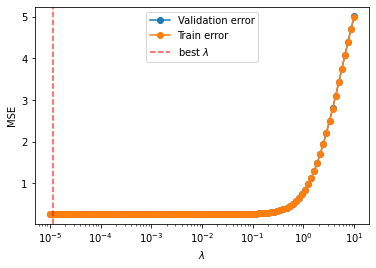

In [13]:
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [-3] * D
high_D = [3] * D

# Generate training set
Xtr, Ytr = linearRegrFunction(n,D,low_D,high_D,truew,sigma_noise)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)


# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

Plot the regression curve using the best $\lambda$ (found with `KFoldCVRLS`) and using the worst $\lambda$

[--] best lambda found: 1.1497569953977357e-05


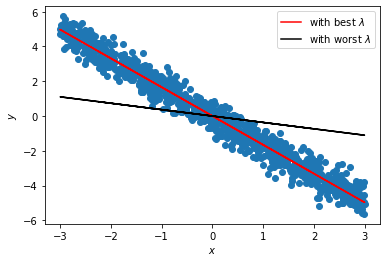

In [14]:
# best and worst lambda are the same????
worst_lam = 10
print("[--] best lambda found: {}".format(bestlam))
w_best = regularizedLSTrain(Xtr,Ytr,bestlam)
Ypred_best = regularizedLSTest(w_best, Xtr)

w_worst = regularizedLSTrain(Xtr,Ytr,worst_lam)
Ypred_worst = regularizedLSTest(w_worst, Xtr)

_, ax = plt.subplots()
ax.scatter(Xtr, Ytr)
ax.plot(Xtr, Ypred_best, '-',c="red", label="with best $\lambda$")
ax.plot(Xtr, Ypred_worst, '-',c="black", label="with worst $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend(loc="best")

Use the best $\lambda$ found to train the model on the full training set and compute the test error on the following test set.   

In [15]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, truew, sigma_noise)

print("[--] best lambda found: {}".format(bestlam))

w_best = regularizedLSTrain(Xte,Yte,bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)

test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))


[--] best lambda found: 1.1497569953977357e-05
[--] Test error: 0.2544093556391116


### Repeat the procedure on a different dataset

Create new training **and** test datasets, sampled in a non-symmetric range (for example you can set the `low_D` and `high_D` parameters of the `linearRegrFunction` function to 2 and 5).

Then repeat the K-fold CV procedure, and check whether the best regularization parameter changes!

[--] best lambda found: 0.0005722367659350221
[--] Test error: 0.2527427697133408


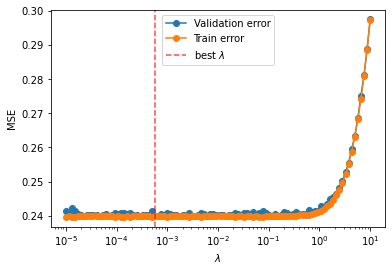

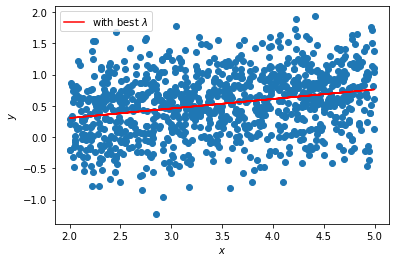

In [16]:
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [2] * D   # low_D and high_D changed as requested
high_D = [5] * D

# Generate training set
Xtr, Ytr = linearRegrFunction(n,D,low_D,high_D,truew,sigma_noise)
# Generate test set
Xte, Yte = linearRegrFunction(n,D,low_D,high_D,truew,sigma_noise)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)


# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

print("[--] best lambda found: {}".format(bestlam))
w_best = regularizedLSTrain(Xtr,Ytr,bestlam)
Ypred_best = regularizedLSTest(w_best, Xtr)

_, ax = plt.subplots()
ax.scatter(Xtr, Ytr)
ax.plot(Xtr, Ypred_best, '-',c="red", label="with best $\lambda$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.legend(loc="best")

w_best = regularizedLSTrain(Xte,Yte,bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)

test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))
